In [1]:
import sys 
import os
#import pandahelper as pdh


import cymetric as cym
import pandas as pd

import numpy as np
import sklearn as skl
from sklearn import datasets
import random

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40,24)
from cymetric import graphs as cgr
from cymetric import timeseries as tm
from cymetric import filters as fl


In [2]:
#u_model.sqlite
file = "u_model.sqlite"
db = cym.dbopen(file)
ev = cym.Evaluator(db=db, write=True)

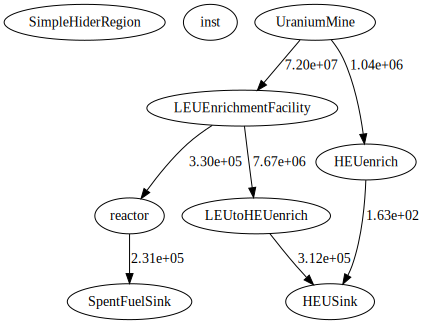

In [3]:
cym.graphs.flow_graph(ev, label = "mass")

In [4]:
agentTable = ev.eval("AgentEntry")
#print(type(agentTable))
#print(agentTable)
agents = agentTable.loc[:, ["AgentId", "Prototype"]]
print(agents)

transTable = ev.eval("Transactions")
transactions = transTable.loc[:, ["SenderId", "ReceiverId", "ResourceId", "Commodity", "Time"]]
print(transactions)
print (transactions['ReceiverId'].unique())
    
resourceTable = ev.eval("Resources")
resources = resourceTable.loc[:, ["ResourceId", "Quantity"]]
print(resources)

   AgentId              Prototype
0       15      SimpleHiderRegion
1       16                   inst
2       17            UraniumMine
3       18  LEUEnrichmentFacility
4       19                reactor
5       20          SpentFuelSink
6       21              HEUenrich
7       22         LEUtoHEUenrich
8       23                HEUSink
     SenderId  ReceiverId  ResourceId Commodity  Time
0          17          18          14    c_uore     0
1          17          21          16    c_uore     0
2          18          19          35     c_leu     1
3          18          19          41     c_leu     1
4          18          19          47     c_leu     1
..        ...         ...         ...       ...   ...
513        21          23        3363     c_heu   142
514        22          23        3366     c_heu   142
515        17          21        3378    c_uore   143
516        18          22        3381     c_leu   143
517        21          23        3387     c_heu   143

[518 rows x

In [5]:
def tidy_df(file):
    db = cym.dbopen(file)
    ev = cym.Evaluator(db=db, write=True)
    
    agentTable = ev.eval("AgentEntry")
    #print(type(agentTable))
    #print(agentTable)
    agents = agentTable.loc[:, ["AgentId", "Prototype"]]
    #print(agents)
    
    transTable = ev.eval("Transactions")
    transactions = transTable.loc[:, ["SenderId", "ReceiverId", "ResourceId", "Commodity", "Time"]]
    #print(transactions)
    
    resourceTable = ev.eval("Resources")
    resources = resourceTable.loc[:, ["ResourceId", "Quantity"]]
    #resources
    
    #merge agents, transactions, and resources
    int1 = pd.merge(transactions, resources, on='ResourceId', how='inner')
    #int1
    #rename AgentId column to facilitate merge 
    send = agents.rename(columns = {"AgentId": "SenderId"})
    receive = agents.rename(columns = {"AgentId": "ReceiverId"})
    #int2 = pd.merge(int1, send, on = "SenderId", how = "inner")
    #int3 = pd.merge(int2, receive, on = "ReceiverId", how = "inner")

    for i in range(len(int1)):
        for j in range(len(send)):
            if int1.loc[i,"SenderId"] == send.loc[j, "SenderId"]:
                int1.loc[i,"SenderId"] = send.loc[j, "Prototype"]
    int1
    for i in range(len(int1)):
        for j in range(len(receive)):
            if int1.loc[i,"ReceiverId"] == receive.loc[j, "ReceiverId"]:
                int1.loc[i,"ReceiverId"] = receive.loc[j, "Prototype"]

    
    return int1
    #tidy = spread(int1)
    #return tidy

def spread(df):
    #conceal commodity transactions
    material = [] 
    print(df["Commodity"].size)
    for row in df["Commodity"]:
        #print (row)
        if row == "c_uore":
            material.append("ore")
        if row == "c_leu" or row == "c_heu":
            material.append("fuel")
        if row == "c_spent_leu":
            material.append("spent")
    print(len(material))
    df["material"] = material
    
    int2 = df[["Time", "Quantity", "material"]]
    
    return int2
    #merge back indexed by time
    
    

In [6]:
leu_data = tidy_df("leuonly.sqlite")
print(leu_data)

           SenderId       ReceiverId  ResourceId Commodity  Time  \
0       UraniumMine  EnrichmentPlant           8      uore     0   
1   EnrichmentPlant              LWR          22  freshuox     1   
2   EnrichmentPlant              LWR          28  freshuox     1   
3   EnrichmentPlant              LWR          34  freshuox     1   
4       UraniumMine  EnrichmentPlant          39      uore     2   
5               LWR    SpentFuelSink          72  spentuox    19   
6   EnrichmentPlant              LWR          83  freshuox    19   
7       UraniumMine  EnrichmentPlant          88      uore    20   
8               LWR    SpentFuelSink         123  spentuox    38   
9   EnrichmentPlant              LWR         134  freshuox    38   
10      UraniumMine  EnrichmentPlant         139      uore    39   
11              LWR    SpentFuelSink         174  spentuox    57   
12  EnrichmentPlant              LWR         185  freshuox    57   
13      UraniumMine  EnrichmentPlant         190

In [7]:
tidy_data = tidy_df("u_model.sqlite")
print(tidy_data)

                  SenderId             ReceiverId  ResourceId Commodity  Time  \
0              UraniumMine  LEUEnrichmentFacility          14    c_uore     0   
1              UraniumMine              HEUenrich          16    c_uore     0   
2    LEUEnrichmentFacility                reactor          35     c_leu     1   
3    LEUEnrichmentFacility                reactor          41     c_leu     1   
4    LEUEnrichmentFacility                reactor          47     c_leu     1   
..                     ...                    ...         ...       ...   ...   
513              HEUenrich                HEUSink        3363     c_heu   142   
514         LEUtoHEUenrich                HEUSink        3366     c_heu   142   
515            UraniumMine              HEUenrich        3378    c_uore   143   
516  LEUEnrichmentFacility         LEUtoHEUenrich        3381     c_leu   143   
517              HEUenrich                HEUSink        3387     c_heu   143   

           Quantity  
0    

In [8]:
#CHECK FOR MISSING FACILITIES HERE!!!!!!!!!!!

#rename facilities and mask material 
#1) assume all of the enrichment happens in one building 
senders = []
for row in tidy_data["SenderId"]: 
    if "nrich" in row: 
        senders.append("enrichment")       
    elif "Mine" in row: 
        senders.append("mine")
    else:
        senders.append("reactor")
receivers = []
for row in tidy_data["ReceiverId"]:
    if "nrich" in row: 
        receivers.append("enrichment")
    else: 
        receivers.append(row)
senders = pd.Series([s for s in senders])
receivers = pd.Series([r for r in receivers])
#2) remove commodity labels
set1 = pd.concat([senders, receivers, tidy_data["Time"], tidy_data["Quantity"]], axis = 1)
set1.columns = ["sender", "receiver", "timestep", "kg"]
set1

,sender,receiver,timestep,kg
0,mine,enrichment,0,1000000.000000
1,mine,enrichment,0,1000000.000000
2,enrichment,reactor,1,33000.000000
3,enrichment,reactor,1,33000.000000
4,enrichment,reactor,1,33000.000000
5,enrichment,enrichment,1,12081.081081
6,enrichment,HEUSink,1,1.140265
7,mine,enrichment,2,1000000.000000
8,mine,enrichment,2,248.860741
9,enrichment,HEUSink,2,1.140265


In [9]:
#remove rows going from enrichment to enrichment 
enrichrows = []
for i in range(len(set1)):
    if set1.iloc[i, 0] == set1.iloc[i, 1]:
        enrichrows.append(i)

set2 = set1.drop(enrichrows, axis = 0)
set2.head(7)

,sender,receiver,timestep,kg
0,mine,enrichment,0,1000000.000000
1,mine,enrichment,0,1000000.000000
2,enrichment,reactor,1,33000.000000
3,enrichment,reactor,1,33000.000000
4,enrichment,reactor,1,33000.000000
6,enrichment,HEUSink,1,1.140265
7,mine,enrichment,2,1000000.000000


In [10]:
#condense information by timestep
transactions = {}
for i in range(144):
    transactions[i] = []

for i in range(len(set2)):
    transactions[set2.iloc[i,2]].append({"sender": set2.iloc[i,0], "receiver": set2.iloc[i,1], "kg": set2.iloc[i,3]})
transactions
print("SpentFuelSink" in transactions)



False


In [11]:
#consolidate transactions between same facilities in same timestep (from merging enrichments)

#remove transactions from enrichment to enrichment 
def check_duplicate(timesteplist):
    trans_pairs = set()
    for transaction in timesteplist: 
        pair = transaction["sender"], transaction["receiver"], 
        
    #make set of transaction pairs
    #if pair is already in set, sum the quantity sent between the duplicate pair 


In [12]:
#weight limit for shipping containers is 20000kg 